# Bulk RNA-Seq
In this tutorial we are going to run through how UCDeconvolve can be used to aid in the analysis and annotation of
bulk RNA-Sequencing data. For this tutorial, we are going to recreate part of the analysis in Figure 5 of the
unicell deconvolve manuscript, where we analyze bulk-RNA-Seq data from 
patients at various stages of Type 2 Diabetes from a prior study ``GSE50244``.

## Loading Packages & Authenticating
The first step in this analysis will be to load scanpy and ucdeconvolve after following the installation and registration instructions, and
authenticate our API. In this tutorial we saved our user access token in the variable ``TOKEN``.

In [17]:
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import requests
import io

import ucdeconvolve as ucd
ucd.api.authenticate(TOKEN)

2023-04-25 17:23:16,217|[UCD]|INFO: Updated valid user access token.


## Download and Pre-Process Data

We will download a preprocessed version of the target dataset from an online repository. This dataset contains expression
data from pancreatic islet biopsies from ~100 patients at varying stages of T2D.

In [3]:
url = "https://github.com/dchary/ucdeconvolve_paper/raw/main/figure5/adata_t2d_GSE50244.h5ad"
adata = sc.read_h5ad(io.BytesIO(requests.get(url).content))

## Run UCDBase For Context-Free Prediction

We begin by obtaining context-free cell type predictions using UCDBase. 

In [5]:
ucd.tl.base(adata)

2023-04-25 17:19:09,360|[UCD]|INFO: Starting UCDeconvolveBASE Run. | Timer Started.
Preprocessing Dataset | 100% (1 of 1) |##| Elapsed Time: 0:00:00 Time:  0:00:00
2023-04-25 17:19:10,062|[UCD]|INFO: Uploading Data | Timer Started.
2023-04-25 17:19:10,917|[UCD]|INFO: Upload Complete | Elapsed Time: 0.854 (s)
Waiting For Submission : UNKNOWN | Queue Size : 0 | \ |#| 2 Elapsed Time: 0:00:03
Waiting For Submission : QUEUED | Queue Size : 1 | / |#| 4 Elapsed Time: 0:00:06
Waiting For Submission : RUNNING | Queue Size : 1 | | |#| 4 Elapsed Time: 0:00:06
Waiting For Completion | 100% (77 of 77) || Elapsed Time: 0:00:14 Time:  0:00:14
2023-04-25 17:19:33,178|[UCD]|INFO: Download Results | Timer Started.
2023-04-25 17:19:33,417|[UCD]|INFO: Download Complete | Elapsed Time: 0.239 (s)
2023-04-25 17:19:34,084|[UCD]|INFO: Run Complete | Elapsed Time: 24.723 (s)


### Examine Differences in Pancreatic Beta Cell Fractions Across Disease States
We want to look at differences in cell type fractions between patients stratified by disease state. Late-stage T2D is characterized
by a loss of beta cells. Let's see if this dataset is concordant with this hypothesis.

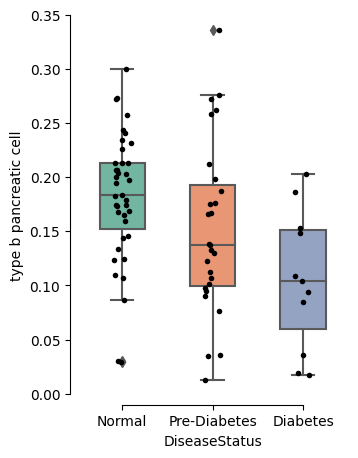

In [34]:
# Load only beta cell predictions
preds = ucd.utils.read_results(adata, celltypes = ['type b pancreatic cell'])

# Append to adata as a column
adata.obs['type b pancreatic cell'] = preds['type b pancreatic cell']

# Plot boxplots
fig, ax = plt.subplots(figsize = (3.5,5))
sns.boxplot(data = adata.obs, x = 'DiseaseStatus', y = 'type b pancreatic cell',
            order = ['Normal', 'Pre-Diabetes', 'Diabetes'], ax = ax,
            palette="Set2", width = 0.5)
sns.stripplot(data = adata.obs, x = 'DiseaseStatus', y = 'type b pancreatic cell',
            order = ['Normal', 'Pre-Diabetes', 'Diabetes'], ax = ax, color = 'k', size = 4)
sns.despine(ax = ax, trim = True, offset = 5)


## Run UCDSelect For Contextualized Predictions

We may want to leverage a pancreas-specific reference dataset to explore more detail subtypes, but also to confirm
the findings suggested by our context-free approach. We can use UCDSelect to do this, which leverages
a transfer learning regime utilizing UCDBase as a feature extraciton engine to calculate cell-type features for an input
target dataset and an annotated reference dataset. 

UCDSelect comes with pre-built reference datasets for common tissue types. To view datasets available as prebuilt
references, run the utility function ``ucd.utils.list_prebuilt_references()``. 


%%eval-rst
.. note::
    Would you like to have a particular study incorporated as a prebuilt reference? Email us at ``ucdeconvolve@gmail.com``
    and let us know!

In [35]:
ucd.utils.list_prebuilt_references()

['allen-mouse-cortex', 'enge2017-human-pancreas', 'lee-human-pbmc-covid']

### Running UCDSelect
Let's go ahead and run ucdselect using the *enge2017-human-pancreas* reference.

In [36]:
ucd.tl.select(adata, "enge2017-human-pancreas")

2023-04-25 17:28:26,171|[UCD]|INFO: Starting UCDeconvolveSELECT Run. | Timer Started.
Preprocessing Mix | 100% (1 of 1) |######| Elapsed Time: 0:00:00 Time:  0:00:00
Preprocessing Ref | 100% (1 of 1) |######| Elapsed Time: 0:00:00 Time:  0:00:00
2023-04-25 17:28:27,651|[UCD]|INFO: Uploading Data | Timer Started.
2023-04-25 17:28:28,784|[UCD]|INFO: Upload Complete | Elapsed Time: 1.132 (s)
Waiting For Submission : UNKNOWN | Queue Size : 0 | / |#| 0 Elapsed Time: 0:00:00
Waiting For Submission : QUEUED | Queue Size : 1 | - |#| 1 Elapsed Time: 0:00:01
Waiting For Submission : RUNNING | Queue Size : 1 | | |#| 1 Elapsed Time: 0:00:01
Waiting For Completion | 100% (77 of 77) || Elapsed Time: 0:00:22 Time:  0:00:22
2023-04-25 17:29:12,832|[UCD]|INFO: Download Results | Timer Started.
2023-04-25 17:29:12,958|[UCD]|INFO: Download Complete | Elapsed Time: 0.125 (s)
2023-04-25 17:29:13,621|[UCD]|INFO: Run Complete | Elapsed Time: 47.449 (s)


Let's go ahead and read our results, where we see only pancreas-specific
cell types being deconvoled which were annotated in the original reference.

In [38]:
ucd.utils.read_results(adata, key = 'ucdselect').head(5)

,beta,alpha,ductal,delta,acinar,mesenchymal
sample_id,,,,,,
GSM1216753,0.000859,0.048488,0.704008,0.119697,0.126949,0.000000
GSM1216755,0.126114,0.124226,0.000000,0.000000,0.710946,0.038713
GSM1216758,0.365763,0.102278,0.000000,0.000000,0.000000,0.531958
GSM1216760,0.566138,0.015259,0.000000,0.000000,0.207783,0.210820
GSM1216763,0.000000,0.066785,0.125175,0.000000,0.396808,0.411232


Let's repeat our boxplot plotting and look at results for type b pancreatic cells when using a contextualized reference
for deconvolution with fine-tuning.

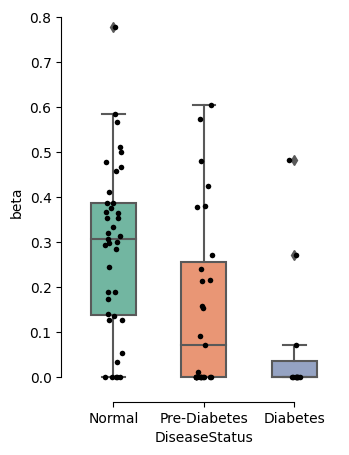

In [58]:
# Load only beta cell predictions
preds = ucd.utils.read_results(adata, key = 'ucdselect', celltypes = ['beta'])

# Append to adata as a column
adata.obs['beta'] = preds['beta']

# Plot boxplots
fig, ax = plt.subplots(figsize = (3.5,5))
sns.boxplot(data = adata.obs, x = 'DiseaseStatus', y = 'beta',
            order = ['Normal', 'Pre-Diabetes', 'Diabetes'], ax = ax,
            palette="Set2", width = 0.5)
sns.stripplot(data = adata.obs, x = 'DiseaseStatus', y = 'beta',
            order = ['Normal', 'Pre-Diabetes', 'Diabetes'], ax = ax, color = 'k', size = 4)
sns.despine(ax = ax, trim = True, offset = 5)


We can see that islet samples in the Diabetes cohort exhibit almost no detectable beta cells, which patients who are
otherwise healthy report a predicted beta cell median fraction of ~30%. Note that while the trend of relative proportions between ucdbase and ucdselect is the same,
the absolute proportions were different. Healthy islets are often ~70% beta cells, however these bulk islet samples likely represent imperfect dissections, with ~50% of the tissue predicted to represent pancreatical acinar / ductal epithelial cells and mesencyhmal stroma.